In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Embedding, LSTM, Dense
import matplotlib.pyplot as plt

In [ ]:
VOCAB_SIZE = 20000
ENGLISH_SEQUENCE_LENGTH = 64
FRENCH_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 300
BATCH_SIZE=8
HIDDEN_UNITS = 256

## Data Preparation

In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2023-07-18 13:30:17--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7420323 (7.1M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.08M  20.1MB/s    in 0.4s    

2023-07-18 13:30:17 (20.1 MB/s) - ‘fra-eng.zip’ saved [7420323/7420323]



In [ ]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


In [ ]:
!wc -l /content/dataset/fra.txt

217975 /content/dataset/fra.txt


In [ ]:
!head -10000 /content/dataset/fra.txt > /content/dataset/fra_10000.txt

## Preprocessing

In [ ]:
text_dataset = tf.data.TextLineDataset("/content/dataset/fra_10000.txt")
text_dataset

<TextLineDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
english_vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [ ]:
french_vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [ ]:
def selector(input_text):
  split_text = tf.strings.split(input_text, '\t')
  return {'input_1':split_text[0:1], 'input_2': '[start] ' + split_text[1:2]}, split_text[1:2]+' [end]'
  # {english, french(with start)}, french(with end)

In [ ]:
split_dataset = text_dataset.map(selector)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! [end]'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. [end]'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! [end]'], dtype=object)>)


In [ ]:
def separator(input_text):
  split_text = tf.strings.split(input_text, '\t')
  return split_text[0:1], '[start] ' + split_text[1:2]+' [end]'

In [ ]:
init_dataset = text_dataset.map(separator)

In [ ]:
for i in init_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Va ! [end]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] Marche. [end]'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'[start] En route ! [end]'], dtype=object)>)


In [ ]:
english_training_data = init_dataset.map(lambda x,y : x) # input x,y and output x # only for english
english_vectorize_layer.adapt(english_training_data)

In [ ]:
# check the vectorize layer
english_vectorize_layer.get_vocabulary()[10]

'we'

In [ ]:
french_training_data = init_dataset.map(lambda x,y : y) # input x,y and output x # only for english
french_vectorize_layer.adapt(french_training_data)

In [ ]:
def vectorizer(inputs, output):
  return {'input_1' :english_vectorize_layer(inputs['input_1']),
          'input_2': french_vectorize_layer(inputs['input_2'])}, french_vectorize_layer(output)

In [ ]:
dataset = split_dataset.map(vectorizer)

In [ ]:
# check if each inputs are mapped with the adapted vectorizer
for i in dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[ 2, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[39,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0

### Batch/Split

In [ ]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
NUM_BATCHES=int(10000/BATCH_SIZE)
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

# Concepts in Transformer

## Self-attention
- Problem of seq2seq model
    - When transferring information from the encoder to the decoder, relying on just the single context vector will cause much information to be lost by the time we get to the last unit.
- Attention mechanism
    - Find how similar words are in the encoder and with the decoder.
    - Attention Score: How each encoder tokens influences the decoder token
    - Query: Previous hidden state of decoder
    - Key, Value: Encoder hidden state
- Self-attention
    - Find how similar is each and every word in the input to one another
    - Remove RNN -> Capable of parallel processing

![scaled_dot](https://jamesmccaffrey.files.wordpress.com/2020/09/sdpa_picture_and_equation.jpg?w=584&h=246)

See this:https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms

## Multi-head Attention

![multi_head](https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png)

(seq_len, embed_dim) -> (seq_len, hs_linear) -> (seq_len, hs_linear * h)

## Layer Normalization

- Batch Normalization is not used in NLP -> NLP batch statistics exhibit "large variance" throughout training (poor performance) (From powerNorm paper)
- Layer Normalization normalizes across the features of a single batch

## Encoder

### Positional Encoding


참고: https://www.blossominkyung.com/deeplearning/transfomer-positional-encoding


![image.png](https://machinelearningmastery.com/wp-content/uploads/2022/01/PE3.png)

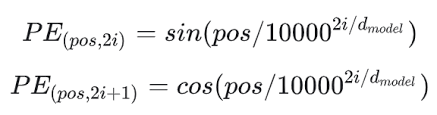

In [6]:
SEQ_LEN = 64
def positional_encoding(model_size, SEQ_LEN):
  output = []
  for pos in range(SEQ_LEN):
    PE = np.zeros((model_size)) # (512)
    for i in range(model_size):
      if i%2 == 0:
        PE[i] = np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i] = np.cos(pos/(10000**((i-1)/model_size)))
    output += [tf.expand_dims(PE, axis=0)] # (1,512)
  out = tf.concat(output, axis=0) # (SEQ_LEN, model_size)
  out = tf.expand_dims(out, axis=0) # (1, SL, ms)
  return tf.cast(out, dtype=tf.float32)

In [ ]:
o = [np.zeros((1,512)), np.zeros((1,512))]
tf.concat(o, axis=0)

<tf.Tensor: shape=(2, 512), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

In [5]:
positional_encoding(512).shape

TensorShape([1, 64, 512])

### Embeddings

In [12]:
class Embeddings(Layer):
  def __init__(self, vocab_size, sequence_length, embedding_dim):
    super(Embeddings, self).__init__()
    self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
    self.vocab_size = vocab_size
    self.sequence_length = sequence_length
    self.embedding_dim = embedding_dim

  def call(self, inputs):
    embedded = self.embedding(inputs) # (bs, seq_len, embed_dim)
    positions = positional_encoding(self.embedding_dim, self.sequence_length) # (bs, seq_len, embed_dim)
    return embedded + positions

  def compute_mask(self, inputs, mask=None):
    mask = tf.math.not_equal(inputs, 0) # False where 0
    # Create a matrix
    mask1 = mask[:, :, tf.newaxis] # (bs, seq_len, 1)
    mask2 = mask[:, tf.newaxis, :] # (bs, 1, seq_len)
    attention_mask = mask1 & mask2 # (bs, seq_len, seq_len) # all the padded values are False otherwise True
    return attention_mask

In [16]:
ebd = Embeddings(vocab_size=20000, sequence_length=64, embedding_dim=256)
ebd(tf.zeros((5, 64))).shape
# ebd.compute_mask(tf.zeros((5, 64)))

TensorShape([5, 64, 256])

#### compute_mask : creates 0 mask for padded values

In [7]:
a = tf.constant([[2, 231, 5, 7, 8, 0, 0, 0]])
mask = tf.math.not_equal(a, 0) # true if not 0
mask

<tf.Tensor: shape=(1, 8), dtype=bool, numpy=array([[ True,  True,  True,  True,  True, False, False, False]])>

In [9]:
# tf.newaxis works same with tf.expand_dims
mask1 = mask[:,:, tf.newaxis] # (1, 8, 1)
mask2 = mask[:, tf.newaxis, :] # (1, 1, 8)
print(mask1&mask2)

tf.Tensor(
[[[ True  True  True  True  True False False False]
  [ True  True  True  True  True False False False]
  [ True  True  True  True  True False False False]
  [ True  True  True  True  True False False False]
  [ True  True  True  True  True False False False]
  [False False False False False False False False]
  [False False False False False False False False]
  [False False False False False False False False]]], shape=(1, 8, 8), dtype=bool)
